# Data preprocessing

In [1]:
import os
from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
!wget -c https://files.deeppavlov.ai/field-matters/releases/demo/sound.zip
!wget -c https://files.deeppavlov.ai/field-matters/releases/demo/dia_data.csv
!unzip sound.zip #your audios here

--2022-06-02 09:58:11--  https://files.deeppavlov.ai/field-matters/releases/demo/sound.zip
Resolving files.deeppavlov.ai (files.deeppavlov.ai)... 178.63.27.41
Connecting to files.deeppavlov.ai (files.deeppavlov.ai)|178.63.27.41|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2022-06-02 09:58:12--  https://files.deeppavlov.ai/field-matters/releases/demo/dia_data.csv
Resolving files.deeppavlov.ai (files.deeppavlov.ai)... 178.63.27.41
Connecting to files.deeppavlov.ai (files.deeppavlov.ai)|178.63.27.41|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  sound.zip
  inflating: audio_to_release/ckt/A chatterbox and a wanton girl-0-0.mp4  
  inflating: audio_to_release/ckt/A chatterbox and a wanton girl-1-0.mp4  
  inflating: audio_to_release/ckt/An evil spirit and a dicky bird

In [3]:
import pandas as pd
df = pd.read_csv('dia_data.csv') #your dataset

In [4]:
df['fpath'] = './audio_to_release/' + df['lang'] + '/' + df['source']

In [5]:
df['fpath'] = df['fpath'].apply(lambda x: x.replace(' ', '_')) #removing spaces in dataset's paths

In [6]:
all_paths = df['fpath']
all_paths = list(set(all_paths))

In [7]:
df = df.reset_index() #adding indexes(id)

In [8]:
df2 = pd.DataFrame(df.drop(['speaker', 'source', 'lang', 'index'], axis=1).groupby('fpath').apply(dict)).reset_index()
df2['coord_start'] = df2[0].apply(lambda x: list(x['start'])[0])
df2['coord_end'] = df2[0].apply(lambda x: list(x['end'])[-1])
df2

,fpath,0,coord_start,coord_end
0,./audio_to_release/mhr/mhr-StTor-100118-ANF_ZV...,"{'start': [19.529], 'end': [21.29600000000005]...",19.529,38.354
1,./audio_to_release/mhr/mhr-StTor-100118-ANF_ZV...,"{'start': [20.15099999999996], 'end': [21.3250...",20.151,39.441
2,./audio_to_release/mhr/mhr-StTor-100118-ANF_ZV...,"{'start': [20.423999999999968], 'end': [22.865...",20.424,38.767
3,./audio_to_release/mhr/mhr-StTor-100118-ANF_ZV...,"{'start': [22.1099999999999], 'end': [22.70299...",22.110,40.325
4,./audio_to_release/mhr/mhr-StTor-100118-ANF_ZV...,"{'start': [18.18100000000001], 'end': [21.9610...",18.181,41.311
...,...,...,...,...
209,./audio_to_release/sah/game_885-1785s-2-2.mp4,"{'start': [21.166999999999998], 'end': [21.523...",21.167,37.762
210,./audio_to_release/sah/game_885-1785s-2-3.mp4,"{'start': [25.99700000000001], 'end': [29.4730...",25.997,41.180
211,./audio_to_release/sah/game_885-1785s-2-4.mp4,"{'start': [21.35500000000001], 'end': [22.3290...",21.355,42.167
212,./audio_to_release/yrk/TOYa_audio_TNenets.wav,"{'start': [0.2339999999999999], 'end': [5.186]...",0.234,39.866


In [9]:
def cutter(row): #cutting files accroding to timecodes
    fpath, start, end, index = row["fpath"], row["coord_start"], row["coord_end"], row["fpath"]
    !ffmpeg -n -i {fpath} -ss {str(start)} -to {str(end)} -ar 16000 \
     {str(index)}.wav

    
df2.progress_apply(cutter, axis=1)

  0%|          | 0/214 [00:00<?, ?it/s]

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

0      None
1      None
2      None
3      None
4      None
       ... 
209    None
210    None
211    None
212    None
213    None
Length: 214, dtype: object

In [10]:
dirs = os.listdir("./audio_to_release") 
for i in range(len(dirs)): #all directories
    dirs[i] = "./audio_to_release/" + dirs[i] 

def remover(directory): #getting rid of original files
    for item in os.listdir(directory):
        if (not '.wav.wav' in item) and (not '.mp4.wav' in item) and (not '.WAV.wav' in item):
            os.remove(os.path.join(directory, item))
            
for item in dirs:
    remover(item)

In [11]:
def replacer(fpath): #new paths in dataframe's column 'fpath' according to new file names
    fpath = fpath.replace('.wav', '.wav.wav').replace('.mp4', '.mp4.wav').replace('.WAV', '.WAV.wav')
    return fpath

df['fpath'] = df['fpath'].apply(replacer)

In [12]:
all_paths = set(list(df['fpath']))

# New shape for dataset

This whole section is dedicated to reformating the dataset. After manipulations below, anntoation for speakers can be obtained (for each recording).

In [13]:
path_dict = {}
for idx, row in df.iterrows():
    if row['fpath'] in path_dict:
        if row['speaker'] in path_dict[row['fpath']]:
            path_dict[row['fpath']][row['speaker']]['start'].append(row['start'])
            path_dict[row['fpath']][row['speaker']]['end'].append(row['end'])
        else:
            path_dict[row['fpath']][row['speaker']] = {'start': [row['start']], 'end' : [row['end']]}
    else:
        path_dict[row['fpath']] = {row['speaker']: {'start': [row['start']], 'end' : [row['end']]}}

In [14]:
path_dict_new = {}
for path in path_dict.keys():
    path_dict_new[path] = {}
    for speaker in path_dict[path].keys():
        path_dict_new[path][speaker] = {}
        times = path_dict[path][speaker]
        for i in range(1, len(times['start'])+1):
            path_dict_new[path][speaker][i] = [times['start'][i-1], times['end'][i-1]]

In [15]:
new_df = pd.DataFrame(path_dict_new.items(), columns=['file_path', 'source_data'])

In [16]:
new_df['speakers'] = new_df['source_data'].apply(len) #determining the number of speakers for each audio

In [17]:
new_df.to_csv('new_shape.csv')

# Diarization

In [18]:
!pip install pyannote.audio pyannote.core
!pip install pydub

In [19]:
from pyannote.audio.features import RawAudio
from IPython.display import Audio
from sklearn.cluster import KMeans
from pyannote.core import Segment, notebook
import torch

In [20]:
from pyannote.audio.features import RawAudio
from IPython.display import Audio

In [21]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
pipeline = torch.hub.load('pyannote/pyannote-audio', 'dia', device=device) #using GPU

def max_loudness_of_segment(seg, waveform, nmax=1): #determining max volume of a segment
    try:
        notebook.crop = seg
        plot = waveform.crop(seg, return_data=False)
        return pd.Series(plot.data.squeeze()).abs().sort_values().tail(nmax).mean()
    except Exception as e:
        print(e, waveform)


Using cache found in /home/jovyan/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /home/jovyan/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /home/jovyan/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /home/jovyan/.cache/torch/hub/pyannote_pyannote-audio_master
/home/jovyan/.imgenv-oleg-baselines-0/lib/python3.7/site-packages/pyannote/audio/embedding/approaches/arcface_loss.py:170: FutureWarning: The 's' parameter is deprecated in favor of 'scale', and will be removed in a future release
  warnings.warn(msg, FutureWarning)
/home/jovyan/.imgenv-oleg-baselines-0/lib/python3.7/site-packages/pyannote/audio/features/pretrained.py:156: UserWarning: Model was trained with 4s chunks and is applied on 2s chunks. This might lead to sub-optimal results.
  warnings.warn(msg)
Using cache found in /home/jovyan/.cache/torch/hub/pyannote_pyannote-audio_master


In [26]:
def diarizator(fpath, speakers): #diarization function
    try:
        clusterer = KMeans(n_clusters=int(speakers)) 
        OWN_FILE = {'audio': fpath}
        waveform = RawAudio()(OWN_FILE)
        #         print(waveform)
        diarization = pipeline(OWN_FILE)

        segments = list(diarization.itersegments())

        segments_loudnesses_df = pd.Series([max_loudness_of_segment(seg, waveform, 3) for seg in segments])
        # clustering by volume: we hypothesise our speakers to have coherent speech volume during the whole rec
        # so we distuinguish different speakers based on their speech volume 
        cluster_ids = clusterer.fit_predict(segments_loudnesses_df.to_numpy().reshape(-1, 1)).tolist() 

        diarization_di = diarization.for_json()
        for diarization_seg, cluster_id in zip(diarization_di["content"], cluster_ids):
            seg_length = diarization_seg["segment"]["end"] - diarization_seg["segment"]["start"]
            label = cluster_id if seg_length > 0.4 else None
            diarization_seg["label"] = label
        return diarization_di
    except Exception as e:
        print(e)

In [27]:
new_df['recognised'] = new_df.progress_apply(lambda x: diarizator(x['file_path'], x['speakers']), axis=1)

  0%|          | 0/214 [00:00<?, ?it/s]

/home/jovyan/.imgenv-oleg-baselines-0/lib/python3.7/site-packages/sklearn/cluster/affinity_propagation_.py:125: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn("All samples have mutually equal similarities. "
/home/jovyan/.imgenv-oleg-baselines-0/lib/python3.7/site-packages/sklearn/cluster/affinity_propagation_.py:125: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn("All samples have mutually equal similarities. "
/home/jovyan/.imgenv-oleg-baselines-0/lib/python3.7/site-packages/sklearn/cluster/affinity_propagation_.py:125: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn("All samples have mutually equal similarities. "


n_samples=2 should be >= n_clusters=3


/home/jovyan/.imgenv-oleg-baselines-0/lib/python3.7/site-packages/sklearn/cluster/affinity_propagation_.py:125: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn("All samples have mutually equal similarities. "
/home/jovyan/.imgenv-oleg-baselines-0/lib/python3.7/site-packages/sklearn/cluster/affinity_propagation_.py:125: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn("All samples have mutually equal similarities. "
/home/jovyan/.imgenv-oleg-baselines-0/lib/python3.7/site-packages/sklearn/cluster/affinity_propagation_.py:125: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn("All samples have mutually equal similarities. "
/home/jovyan/.imgenv-oleg-baselines-0/lib/python3.7/site-packages/sklearn/cluster/affinity_propagation_.py:125: UserWarning: All samples have mutually equal similarities. Retu

n_samples=3 should be >= n_clusters=4
n_samples=2 should be >= n_clusters=4
n_samples=1 should be >= n_clusters=4
n_samples=2 should be >= n_clusters=3
n_samples=2 should be >= n_clusters=3
n_samples=2 should be >= n_clusters=4
n_samples=3 should be >= n_clusters=4


/home/jovyan/.imgenv-oleg-baselines-0/lib/python3.7/site-packages/sklearn/cluster/affinity_propagation_.py:125: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn("All samples have mutually equal similarities. "


n_samples=2 should be >= n_clusters=3
n_samples=2 should be >= n_clusters=4


/home/jovyan/.imgenv-oleg-baselines-0/lib/python3.7/site-packages/sklearn/cluster/affinity_propagation_.py:125: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn("All samples have mutually equal similarities. "


n_samples=2 should be >= n_clusters=3


/home/jovyan/.imgenv-oleg-baselines-0/lib/python3.7/site-packages/sklearn/cluster/affinity_propagation_.py:125: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn("All samples have mutually equal similarities. "
/home/jovyan/.imgenv-oleg-baselines-0/lib/python3.7/site-packages/sklearn/cluster/affinity_propagation_.py:125: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn("All samples have mutually equal similarities. "
/home/jovyan/.imgenv-oleg-baselines-0/lib/python3.7/site-packages/sklearn/cluster/affinity_propagation_.py:125: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn("All samples have mutually equal similarities. "
/home/jovyan/.imgenv-oleg-baselines-0/lib/python3.7/site-packages/sklearn/cluster/affinity_propagation_.py:125: UserWarning: All samples have mutually equal similarities. Retu

# Preparation for evaluation

There are very simple metrics here (for preliminary evaluation)

In [28]:
def len_source(dictionary):
    counter = 0
    for i in dictionary:
        counter+= len(dictionary[i])
    return counter

def len_regignised(lst):
    try:
        return len(lst)
    except:
        return 0

new_df['segs_source'] = new_df['source_data'].apply(len_source) #counting in source file
new_df['segs_recognised'] = new_df['recognised'].apply(len_regignised) #counting in source file

In [30]:
new_df['distance'] = new_df['segs_source']-new_df['segs_recognised']

In [31]:
def speakers_rec(dictionary):
    lst = []
    try:
        for i in dictionary:
            for j in i:
                if j == 'label':
                    lst.append(i[j])
        return len(set(lst))
    except:
        return 0
new_df['speakers_rec'] = new_df['recognised'].apply(speakers_rec) 

In [32]:
new_df['speaker_distance'] = new_df['speakers']-new_df['speakers_rec'] #distance between the number of speakers
new_df

,file_path,source_data,speakers,recognised,segs_source,segs_recognised,distance,speakers_rec,speaker_distance
0,./audio_to_release/yrk/es100708_MatjPelaNEN.WA...,"{'F2': {1: [48.95399999999999, 49.525]}}",1,"{'pyannote': 'Annotation', 'content': [{'segme...",1,3,-2,0,1
1,./audio_to_release/yrk/TOYa_audio_TNenets.wav.wav,"{'АМК': {1: [0.2339999999999999, 5.186], 2: [5...",1,"{'pyannote': 'Annotation', 'content': [{'segme...",15,3,12,0,1
2,./audio_to_release/sah/game_1-885s-2-1.mp4.wav,"{'1': {1: [21.613000000000003, 22.44], 2: [24....",4,"{'pyannote': 'Annotation', 'content': [{'segme...",14,3,11,0,4
3,./audio_to_release/sah/game_1-885s-0-3.mp4.wav,"{'1': {1: [21.248999999999995, 23.116999999999...",4,"{'pyannote': 'Annotation', 'content': [{'segme...",14,3,11,0,4
4,./audio_to_release/sah/game_1-885s-2-6.mp4.wav,"{'2': {1: [21.80500000000001, 22.4049999999999...",4,"{'pyannote': 'Annotation', 'content': [{'segme...",17,3,14,0,4
...,...,...,...,...,...,...,...,...,...
209,./audio_to_release/mhr/mhr_rus-StTor-100118-AN...,"{'anf': {1: [16.185999999999922, 23.8579999999...",1,"{'pyannote': 'Annotation', 'content': [{'segme...",4,3,1,0,1
210,./audio_to_release/mhr/mhr_rus-StTor-100118-AN...,"{'anf': {1: [23.43699999999989, 25.19499999999...",2,"{'pyannote': 'Annotation', 'content': [{'segme...",5,3,2,0,2
211,./audio_to_release/mhr/mhr_rus-StTor-100118-AN...,"{'anf': {1: [19.65799999999989, 23.86899999999...",2,"{'pyannote': 'Annotation', 'content': [{'segme...",7,3,4,0,2
212,./audio_to_release/mhr/mhr_rus-StTor-100118-AN...,"{'anf': {1: [20.497000000000067, 25.3640000000...",2,"{'pyannote': 'Annotation', 'content': [{'segme...",3,3,0,0,2


In [34]:
new_df.to_csv('diarization.csv')

# Evaluation results

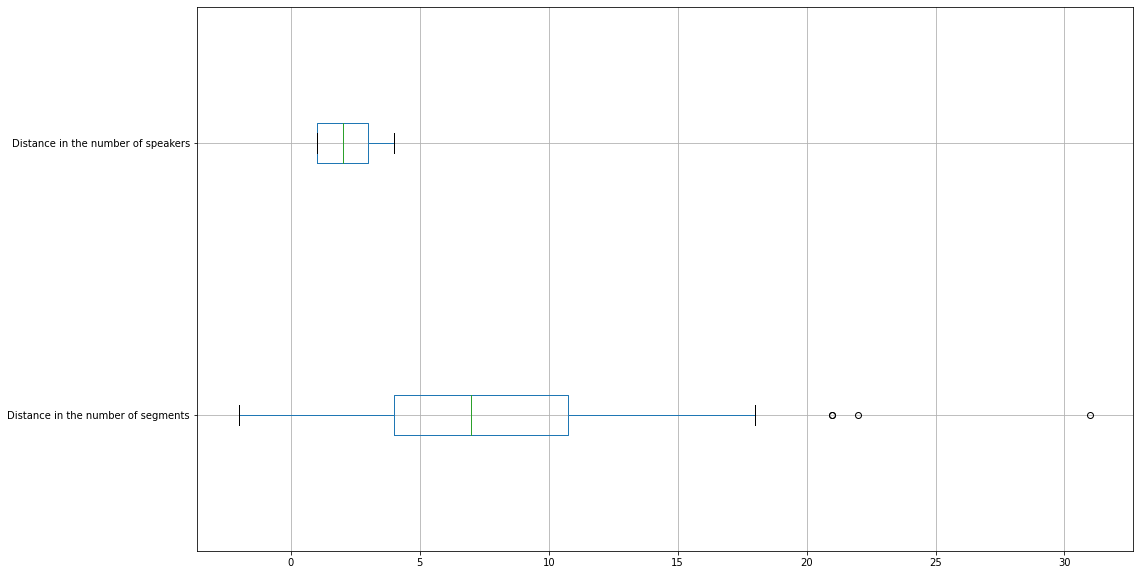

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
x = [list(new_df['distance'].values),
     list(new_df['speaker_distance'].values)]
df = pd.DataFrame(x, index=['Distance in the number of segments', 'Distance in the number of speakers'])


df.T.boxplot(vert=False, figsize=(20,10))
plt.subplots_adjust(left=0.25)
plt.show()